# Proyek Analisis Sentimen Ulasan Google Play Store (Target Bintang 5 - Versi Peningkatan)

Notebook ini berisi langkah-langkah untuk melakukan analisis sentimen pada ulasan aplikasi dari Google Play Store, dengan modifikasi untuk **meningkatkan potensi pencapaian akurasi >92%** (Target Bintang 5).

## SEL 1: INSTALASI & IMPORT LIBRARY

Bagian ini mengimpor semua library yang diperlukan dan memastikan Sastrawi terinstall untuk stemming.

In [15]:
# --- Instalasi Library (Jalankan di awal jika belum terinstall) ---
# Baris %pip biasanya dijalankan langsung di sel notebook
%pip install pandas numpy nltk scikit-learn tensorflow matplotlib seaborn sastrawi transformers torch indoNLP spacy==3.7.0 tqdm joblib imbalanced-learn "dask[complete]" tqdm_joblib tf-keras requests
# (Pilih torch atau tensorflow sebagai backend transformers)

# --- Instalasi Model spaCy Manual (Jalankan SEKALI di awal jika belum) ---
# Jalankan ini di sel notebook terpisah atau di terminal (dengan venv aktif):
%pip install "id_core_news_sm @ https://huggingface.co/firqaaa/id_core_news_sm/resolve/main/id_core_news_sm-any-py3-none-any.whl"

# --- Import Library ---
import re
import os
import json
import time
import uuid
import socket
import functools
import contextlib
import warnings # Untuk mengelola warning jika perlu
import sys      # Untuk mendapatkan path python executable
import requests # Jalankan: pip install requests
import zipfile

# Data Manipulation
import pandas as pd
import numpy as np

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords as nltk_stopwords_corpus # Alias untuk hindari konflik nama
from nltk.tokenize import word_tokenize

# -- NLP: Sastrawi (Stemming & Stopwords Indonesia) --
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    sastrawi_factory = StemmerFactory()
    stemmer = sastrawi_factory.create_stemmer()
    sw_factory = StopWordRemoverFactory()
    sastrawi_stopwords = set(sw_factory.get_stop_words())
    print("✅ Stemmer dan stopwords Sastrawi berhasil diinisialisasi.")
    SASTRAWI_AVAILABLE = True
except ImportError:
    print("⚠️ Sastrawi tidak terinstall. Stemming & stopwords tidak akan dilakukan.")
    stemmer = None; sastrawi_stopwords = set(); SASTRAWI_AVAILABLE = False
except Exception as e:
    print(f"⚠️ Error inisialisasi Sastrawi: {e}. Stemming & stopwords tidak akan dilakukan.")
    stemmer = None; sastrawi_stopwords = set(); SASTRAWI_AVAILABLE = False

# -- NLP: indoNLP (Emoji, Slang Indonesia) --
try:
    from indoNLP.preprocessing import emoji_to_words, replace_slang
    print("✅ Library indoNLP berhasil diimpor.")
    INDONLP_AVAILABLE = True
except ImportError:
    print("⚠️ Library indoNLP tidak terinstall. Fitur emoji & slang tidak akan digunakan.")
    INDONLP_AVAILABLE = False
    # Fallback sederhana jika indoNLP tidak ada
    def emoji_to_words(text): return re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text, flags=re.UNICODE) if isinstance(text, str) else ""
    def replace_slang(text): return text if isinstance(text, str) else ""

# -- NLP: spaCy (Lemmatization Indonesia) - Menggunakan Model Pre-installed --
nlp = None
SPACY_AVAILABLE = False
MODEL_NAME = "id_core_news_sm"
# URL yang berhasil Anda gunakan untuk instalasi manual (untuk referensi/pesan error)
MODEL_INSTALL_URL = "id_core_news_sm @ https://huggingface.co/firqaaa/id_core_news_sm/resolve/main/id_core_news_sm-any-py3-none-any.whl"

try:
    import spacy
    # Langsung coba load model, asumsikan sudah diinstal via pip
    print(f"Mencoba memuat model spaCy '{MODEL_NAME}' yang sudah terinstal...")
    nlp = spacy.load(MODEL_NAME)
    print(f"✅ Model spaCy ('{MODEL_NAME}') berhasil dimuat.")
    SPACY_AVAILABLE = True

except OSError:
    # Model tidak ditemukan -> berarti belum diinstal
    print(f"⚠️ Model spaCy '{MODEL_NAME}' tidak ditemukan.")
    print(f"   Pastikan Anda telah menginstalnya terlebih dahulu.")
    print(f"   Jalankan di terminal/notebook (dengan venv aktif):")
    print(f"   pip install {MODEL_INSTALL_URL}")
    SPACY_AVAILABLE = False
except ImportError:
    # spaCy library itu sendiri tidak terinstall
    print(f"⚠️ Library spaCy tidak terinstall. Jalankan: pip install spacy==3.7.0")
    SPACY_AVAILABLE = False
except Exception as e:
    # Error lain saat mencoba load
    print(f"⚠️ Gagal memuat model spaCy '{MODEL_NAME}': {e}")
    SPACY_AVAILABLE = False

# Cek flag
if SPACY_AVAILABLE:
    print(f"   -> Lemmatization spaCy dengan model '{MODEL_NAME}' siap digunakan.")
else:
    print(f"   -> Lemmatization spaCy tidak akan dilakukan.")

# -- NLP: Transformers (Sentiment Analysis HF) - DENGAN PERBAIKAN LOAD & FALLBACK --
sentiment_analyzer = None
HUGGINGFACE_AVAILABLE = False
try:
    from transformers import pipeline, logging as hf_logging

    primary_model = "mdhugol/indonesia-bert-sentiment-classification"
    fallback_model = "w11wo/indonesian-roberta-base-sentiment-classifier" # Model alternatif

    try:
        print(f"\nMencoba memuat model HF utama: '{primary_model}'...") # Tambah newline untuk pemisah
        sentiment_analyzer = pipeline("sentiment-analysis", model=primary_model, tokenizer=primary_model)
        print(f"✅ Pipeline sentiment analysis HF ('{primary_model}') berhasil dimuat.")
        HUGGINGFACE_AVAILABLE = True
    except Exception as e1:
        print(f"⚠️ Gagal memuat model HF utama '{primary_model}': {e1}")
        print(f"   Mencoba memuat model HF alternatif: '{fallback_model}'...")
        try:
            sentiment_analyzer = pipeline("sentiment-analysis", model=fallback_model, tokenizer=fallback_model)
            print(f"✅ Pipeline sentiment analysis HF alternatif ('{fallback_model}') berhasil dimuat.")
            HUGGINGFACE_AVAILABLE = True
        except Exception as e2:
            print(f"⚠️ Gagal memuat model HF alternatif '{fallback_model}': {e2}")
            print("   Analisis sentimen teks otomatis dan rekonsiliasi label tidak dapat dilakukan.")

    if HUGGINGFACE_AVAILABLE:
        # Kurangi level log Transformers (opsional)
        hf_logging.set_verbosity_error() # Hanya tampilkan error
        print(f"   -> Analisis sentimen HF siap digunakan.")
    else:
        print(f"   -> Analisis sentimen HF tidak tersedia.")


except ImportError:
    print("⚠️ Library 'transformers' tidak terinstall. Rekonsiliasi tidak dapat dilakukan.")
except Exception as e:
    print(f"⚠️ Gagal setup Transformers: {e}. Rekonsiliasi tidak dapat dilakukan.")


# -- NLP: Download Resource NLTK --
print("\nMemeriksa resource NLTK...")
nltk_resources = {'tokenizers/punkt': 'punkt', 'corpora/stopwords': 'stopwords'} # punkt_tab mungkin tidak selalu perlu
all_nltk_res_found = True
for resource_path, resource_name in nltk_resources.items():
    try:
        nltk.data.find(resource_path)
        print(f"- Resource NLTK '{resource_name}' sudah ada.")
    except LookupError:
        all_nltk_res_found = False
        print(f"- Resource NLTK '{resource_name}' tidak ditemukan. Mengunduh...")
        try:
            nltk.download(resource_name, quiet=True)
            print(f"  Unduhan '{resource_name}' selesai.")
        except Exception as nltk_dl_err:
             print(f"  ⚠️ Gagal mengunduh '{resource_name}': {nltk_dl_err}")
if all_nltk_res_found:
    print("Semua resource NLTK yang diperlukan sudah ada.")
else:
     print("Pengecekan/pengunduhan resource NLTK selesai.")

try:
    nltk_stopwords = set(nltk_stopwords_corpus.words('indonesian'))
    print(f"✅ Stopwords NLTK (Indonesia) dimuat ({len(nltk_stopwords)} kata).")
except Exception as e: # Tangkap error lebih umum jika pemuatan gagal
    print(f"⚠️ Gagal memuat stopwords NLTK Indonesia: {e}")
    nltk_stopwords = set()


# Machine Learning (Scikit-learn & Imbalanced-learn)
print("\nMemuat library Machine Learning...")
from sklearn.experimental import enable_halving_search_cv # noqa: F401
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold, HalvingRandomSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print("✅ Library Scikit-learn & Imbalanced-learn dimuat.")

# Deep Learning (TensorFlow / Keras)
print("\nMemuat library Deep Learning (TensorFlow/Keras)...")
TF_KERAS_AVAILABLE = False # Default ke False
try:
    import tensorflow as tf
    # Cek versi TF untuk memastikan > 2.0
    tf_major_version = int(tf.__version__.split('.')[0])
    if tf_major_version < 2:
         print(f"⚠️ Versi TensorFlow ({tf.__version__}) terlalu lama (< 2.0). Beberapa fitur Keras mungkin tidak berfungsi.")
         # Anda bisa memilih untuk raise error atau set TF_KERAS_AVAILABLE = False

    # Import komponen Keras dari TF (best practice untuk TF >= 2.0)
    from tensorflow.keras import Input
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D, BatchNormalization
    from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D, MaxPooling1D,  Activation, Attention, Layer, Concatenate
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.keras.utils import to_categorical
    from sklearn.utils.class_weight import compute_class_weight # Ini dari sklearn, OK

    print(f"✅ TensorFlow versi {tf.__version__} berhasil diimport.")
    TF_KERAS_AVAILABLE = True
except ImportError:
    print("⚠️ TensorFlow/Keras tidak terinstall. Model Deep Learning tidak dapat digunakan.")
except Exception as e:
     print(f"⚠️ Terjadi error saat import TensorFlow/Keras: {e}")


# Visualisasi
print("\nMemuat library Visualisasi...")
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Konfigurasi awal (opsional)
    # sns.set_theme(style="whitegrid")
    print("✅ Library Matplotlib & Seaborn dimuat.")
except ImportError:
    print("⚠️ Matplotlib/Seaborn tidak terinstall. Visualisasi tidak akan tersedia.")
except Exception as e:
    print(f"⚠️ Terjadi error saat import Matplotlib/Seaborn: {e}")


# Utilities & Parallelism
print("\nMemuat library Utilities & Parallelism...")
from tqdm.auto import tqdm # tqdm.auto lebih fleksibel (notebook vs script)
import joblib
from joblib import Memory # Cache untuk fungsi (opsional)

# Penanganan tqdm_joblib yang lebih baik
try:
    from tqdm_joblib import tqdm_joblib
    print("✅ Helper tqdm_joblib ditemukan.")
except ImportError:
    print("⚠️ Helper tqdm_joblib tidak ditemukan. Progress bar Joblib mungkin tidak tampil optimal.")
    # Fallback tetap bisa digunakan jika diperlukan, tapi beri tahu pengguna
    @contextlib.contextmanager
    def tqdm_joblib(tqdm_object): # Fallback definition
        # print("   Menggunakan definisi fallback tqdm_joblib...") # Kurangi verbosity
        class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
            def __call__(self, *args, **kwargs):
                tqdm_object.update(n=self.batch_size)
                return super().__call__(*args, **kwargs)
        old_callback = joblib.parallel.BatchCompletionCallBack
        joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        try:
            yield tqdm_object
        finally:
            joblib.parallel.BatchCompletionCallBack = old_callback
            # tqdm_object.close() # Biarkan joblib yang mengelola penutupan

# Penanganan Dask
DASK_AVAILABLE = False # Default ke False
try:
    import dask.dataframe as dd
    from dask.distributed import Client, progress, wait # Future mungkin tidak perlu diimport langsung di awal
    print("✅ Dask berhasil diimport.")
    DASK_AVAILABLE = True
except ImportError:
    print("⚠️ Dask tidak terinstall (pip install dask[complete]). Fitur paralelisasi Dask tidak tersedia.")
except Exception as e:
    print(f"⚠️ Terjadi error saat import Dask: {e}")


# --- Konfigurasi Global ---
print("\nMenerapkan konfigurasi global...")
pd.set_option('display.max_colwidth', None) # Tampilkan isi kolom teks penuh
# warnings.filterwarnings('ignore') # Hati-hati menggunakan ini, bisa menyembunyikan masalah

print("\n" + "="*60)
print(" ✅ SEMUA IMPORT DAN INISIALISASI AWAL SELESAI ✅ ")
print("="*60 + "\n")

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/34.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/34.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/34.3 MB ? eta -:--:--
     ---------------------------------------- 0.3/34.3 MB ? eta -:--:--
     ---------------------------------------- 0.3/34.3 MB ? eta -:--:--
      -------------------------------------- 0.5/34.3 MB 799.2 kB/s eta 0:00:43
      -------------------------------------- 0.8/34.3 MB 714.3 kB/s eta 0:00:47
      -------------------------------------- 0.8/34.3 MB 714.3 kB/s eta 0:00:47
     - ------------------------------------- 1.0/34.3 MB 762.8 kB/s eta 0:00:44
     - ------------------------------------- 1.3/34.3 MB 771.6 kB/s eta 0:00:43
     - ------------------------------------- 1.3/34.3 MB 771.6 kB/s eta 0:00:43
     - ------------------------------------- 1.6/34.3 MB 806.6 kB/s eta 0:00:41
     -- ------

## SEL 2: MEMUAT DATASET

Memuat dataset CSV hasil scraping.

In [7]:
NAMA_FILE_DATASET = 'hasil_scraping_semua_app.csv' # <<< Nama data yang akan dimuat

try:
    df = pd.read_csv(NAMA_FILE_DATASET)
    print(f"Dataset '{NAMA_FILE_DATASET}' berhasil dimuat.")
    print(f"Jumlah data awal: {len(df)}")
except FileNotFoundError:
    print(f"ERROR: File '{NAMA_FILE_DATASET}' tidak ditemukan. Pastikan file ada di direktori yang sama atau path sudah benar.")
    raise FileNotFoundError(f"Dataset {NAMA_FILE_DATASET} tidak ditemukan.")

# Tampilkan beberapa data awal dan info
print("\nInfo Dataset:")
df.info()
print("\n5 Data Pertama:")
print(df.head())
print("\nContoh Ulasan:")
if not df.empty:
    print(df['content'].iloc[0])
else:
    print("Dataset kosong.")

Dataset 'hasil_scraping_semua_app.csv' berhasil dimuat.
Jumlah data awal: 495604

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495604 entries, 0 to 495603
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   app_id    495604 non-null  object
 1   userName  495602 non-null  object
 2   score     495604 non-null  int64 
 3   at        495604 non-null  object
 4   content   495600 non-null  object
dtypes: int64(1), object(4)
memory usage: 18.9+ MB

5 Data Pertama:
               app_id        userName  score                   at  \
0  com.tokopedia.tkpd     Karno Karno      1  2025-04-19 06:40:56   
1  com.tokopedia.tkpd   Safei Mansyur      5  2025-04-19 06:28:57   
2  com.tokopedia.tkpd  Devinto Axelle      5  2025-04-19 06:24:57   
3  com.tokopedia.tkpd       Yudi Leho      1  2025-04-19 06:14:54   
4  com.tokopedia.tkpd  Jeckson Slamet      5  2025-04-19 06:00:16   

                                      

## SEL 3: DATA CLEANING & PREPROCESSING

**Peningkatan:**
1.  Mempertahankan kata negasi (tidak, jangan, kurang, dll).
2.  Mengaktifkan stemming dengan Sastrawi.

In [8]:
# ==============================================================================
# BAGIAN 1: SETUP TAMBAHAN & VERIFIKASI (HuggingFace, Flags, Stopwords Final)
# ==============================================================================
print("\n--- BAGIAN 1: Setup Tambahan & Verifikasi ---")

# --- Variabel Konfigurasi Baru ---
ENABLE_INDONLP_FEATURES = False # True: Gunakan fitur indoNLP jika tersedia. False: Jangan gunakan fitur indoNLP.
DO_RECONCILIATION = True     # True: Lakukan rekonsiliasi sentimen. False: Gunakan sentimen bintang saja.
# ----------------------------------

# --- Setup Hugging Face (Diperlukan untuk rekonsiliasi) ---
try:
    if 'sentiment_analyzer' not in locals() or sentiment_analyzer is None:
        try:
            from transformers import pipeline, logging as hf_logging
            hf_logging.set_verbosity_error() # Mengurangi output log transformers
            print("Inisialisasi pipeline sentiment analysis Hugging Face...")
            sentiment_analyzer = pipeline(
                "sentiment-analysis", model="mdhugol/indonesia-bert-sentiment-classifier", tokenizer="mdhugol/indonesia-bert-sentiment-classifier"
            )
            print("Pipeline sentiment analysis Hugging Face berhasil dimuat.")
            HUGGINGFACE_AVAILABLE = True
        except ImportError:
            print("PERINGATAN: Library 'transformers' tidak ditemukan. Rekonsiliasi tidak dapat dilakukan.")
            sentiment_analyzer = None; HUGGINGFACE_AVAILABLE = False
        except Exception as e:
            print(f"PERINGATAN: Gagal memuat model/pipeline Hugging Face: {e}. Rekonsiliasi tidak dapat dilakukan.")
            sentiment_analyzer = None; HUGGINGFACE_AVAILABLE = False
    else:
        print("Pipeline sentiment analysis Hugging Face sudah diinisialisasi sebelumnya.")
        if 'HUGGINGFACE_AVAILABLE' not in locals(): HUGGINGFACE_AVAILABLE = True # Asumsi jika var ada
except NameError:
     print("PERINGATAN: Library 'transformers' belum diimport. Rekonsiliasi tidak dapat dilakukan.")
     sentiment_analyzer = None; HUGGINGFACE_AVAILABLE = False
# --------------------------------------------------------------

# Definisikan pola emoji global di sini
emoji_pattern_global = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)

# --- Definisikan Fallback Functions untuk indoNLP (SEBELUM VERIFIKASI) ---
def emoji_to_words_fallback(text):
    """Fallback jika indoNLP tidak ada/tidak aktif: HAPUS emoji."""
    if not isinstance(text, str): return ""
    global emoji_pattern_global
    return emoji_pattern_global.sub(r'', text) # Hapus emoji

def replace_slang_fallback(text):
    """Fallback jika indoNLP tidak ada/tidak aktif: tidak lakukan apa-apa."""
    if not isinstance(text, str): return ""
    return text
# --------------------------------------------------------------------

# --- Verifikasi Variabel Global & Setup Default ---
print("\nMemverifikasi variabel global...")
required_globals = {
    'nltk_stopwords': set, 'sastrawi_stopwords': set, 'stemmer': object, 'nlp': object,
    'INDONLP_AVAILABLE': bool, 'emoji_to_words': callable, 'replace_slang': callable
}
all_vars_ok = True
if 'INDONLP_AVAILABLE' not in globals():
    print("  - PERINGATAN: Variabel global 'INDONLP_AVAILABLE' tidak ditemukan. Diasumsikan False.")
    INDONLP_AVAILABLE = False

for var, expected_type in required_globals.items():
    if var not in globals():
        print(f"  - PERINGATAN: Variabel global '{var}' tidak ditemukan.")
        if var == 'nltk_stopwords': nltk_stopwords = set()
        if var == 'sastrawi_stopwords': sastrawi_stopwords = set()
        if var == 'stemmer': stemmer = None
        if var == 'nlp': nlp = None
        if var == 'emoji_to_words': emoji_to_words = emoji_to_words_fallback
        if var == 'replace_slang': replace_slang = replace_slang_fallback
        all_vars_ok = False

# Tentukan flag efektif USE_INDONLP
USE_INDONLP = INDONLP_AVAILABLE and ENABLE_INDONLP_FEATURES

# Pastikan fungsi fallback digunakan jika USE_INDONLP False
if not USE_INDONLP:
    if 'emoji_to_words' in globals() and globals()['emoji_to_words'] is not emoji_to_words_fallback:
        print("INFO: Penggunaan fitur IndoNLP dinonaktifkan, memastikan emoji_to_words adalah fallback.")
        emoji_to_words = emoji_to_words_fallback
    if 'replace_slang' in globals() and globals()['replace_slang'] is not replace_slang_fallback:
        print("INFO: Penggunaan fitur IndoNLP dinonaktifkan, memastikan replace_slang adalah fallback.")
        replace_slang = replace_slang_fallback

if not all_vars_ok:
    print("  -> Beberapa variabel global penting mungkin tidak ditemukan/didefinisikan dengan benar, fallback digunakan.")

# --- Konfigurasi Stopwords Final dan Flags Proses ---
print("\nKonfigurasi Stopwords Final dan Flags Proses...")
list_stopwords_all = set(globals().get('nltk_stopwords', set())).union(set(globals().get('sastrawi_stopwords', set())))
try:
    negation_file = 'indonesian_negation_words.txt'
    default_negation = {'tidak', 'jangan', 'belum', 'kurang', 'bukan', 'tanpa', 'gak', 'tdk', 'ga',
                       'enggak', 'nggak', 'tak', 'tiada', 'mustahil', 'sulit', 'susah', 'gagal',
                       'nihil', 'kosong', 'dilarang', 'jarang'}
    if not os.path.exists(negation_file):
        with open(negation_file, 'w', encoding='utf-8') as f: f.write("\n".join(default_negation))
        print(f"Membuat file default '{negation_file}'.")
        negation_words = default_negation
    else:
        with open(negation_file, 'r', encoding='utf-8') as f: negation_words = set(line.strip() for line in f if line.strip())
        print(f"Kata negasi ({len(negation_words)}) dibaca dari file.")
except Exception as e:
    negation_words = default_negation
    print(f"Error baca file negasi: {e}. Menggunakan default ({len(negation_words)} kata).")

list_stopwords_final = list_stopwords_all - negation_words
print(f"Total stopwords final (tanpa negasi): {len(list_stopwords_final)}")

CLEANED_DATA_CACHE = 'cleaned_data_reconciled_cache.parquet'
STEMMED_DATA_CACHE = 'stemmed_data_reconciled_cache.parquet'
LEMMATIZED_DATA_CACHE = 'lemmatized_data_reconciled_cache.parquet'
DISTRIBUTION_CACHE = 'input_distribution_cache.json'

# Penyesuaian Flags Proses berdasarkan Konfigurasi dan Ketersediaan
if 'USE_STEMMING' not in globals(): USE_STEMMING = True
if 'USE_LEMMATIZATION' not in globals(): USE_LEMMATIZATION = False

# Sesuaikan DO_RECONCILIATION jika HuggingFace tidak tersedia
if DO_RECONCILIATION and not HUGGINGFACE_AVAILABLE:
    print("PERINGATAN: Rekonsiliasi diminta (DO_RECONCILIATION=True) tetapi HuggingFace tidak tersedia. Rekonsiliasi dinonaktifkan.")
    DO_RECONCILIATION = False

# Cek ulang flags lain berdasarkan ketersediaan komponen aktual
if 'stemmer' not in globals() or globals().get('stemmer') is None : USE_STEMMING = False
if 'nlp' not in globals() or globals().get('nlp') is None : USE_LEMMATIZATION = False

print(f"\n--- Flags Proses Final ---")
print(f"  USE_STEMMING             : {USE_STEMMING}")
print(f"  USE_LEMMATIZATION        : {USE_LEMMATIZATION}")
print(f"  ENABLE_INDONLP_FEATURES  : {ENABLE_INDONLP_FEATURES} (Flag Konfigurasi)")
print(f"  INDONLP_AVAILABLE        : {INDONLP_AVAILABLE} (Ketersediaan Library)")
print(f"  USE_INDONLP (Efektif)    : {USE_INDONLP}")
print(f"  DO_RECONCILIATION        : {DO_RECONCILIATION} (Flag Konfigurasi, mungkin disesuaikan)")
print(f"  HUGGINGFACE_AVAILABLE    : {HUGGINGFACE_AVAILABLE} (Ketersediaan Library)")
print(f"--------------------------")
SPACY_AVAILABLE = 'nlp' in globals() and globals().get('nlp') is not None


# ==============================================================================
# BAGIAN 2: DEFINISI FUNGSI HELPER
# ==============================================================================
print("\n--- BAGIAN 2: Mendefinisikan Fungsi Helper ---")

def create_sentiment_label(score):
    """Buat label sentimen AWAL dari score bintang."""
    try: score_float = float(score); return 'Positif' if score_float > 3 else ('Negatif' if score_float < 3 else 'Netral')
    except (ValueError, TypeError): return 'Invalid Score'

def clean_text(text):
    """Lakukan pembersihan teks dasar. Menggunakan flag USE_INDONLP."""
    if not isinstance(text, str): return ""
    # 1. Pra-pemrosesan awal
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    # 2. Tambah spasi emoji
    global emoji_pattern_global
    try: text = emoji_pattern_global.sub(lambda m: f' {m.group(0)} ', text)
    except Exception as e: print(f"Warning: Gagal menambahkan spasi emoji: {e}")
    # 3. Handle Emoji (konversi/hapus) berdasarkan USE_INDONLP
    global emoji_to_words, USE_INDONLP # Akses flag efektif
    if USE_INDONLP: # Cek flag efektif
        try: text = emoji_to_words(text)
        except Exception as e:
            print(f"Warning: emoji_to_words gagal: {e}. Menghapus sisa emoji.")
            text = emoji_pattern_global.sub(r'', text)
    else: text = emoji_to_words_fallback(text) # Fallback jika USE_INDONLP False
    # 4. Handle Slang berdasarkan USE_INDONLP
    global replace_slang
    if USE_INDONLP: # Cek flag efektif
        try: text = replace_slang(text)
        except Exception as e: print(f"Warning: replace_slang gagal: {e}")
    # 5. Pembersihan Karakter & Case Folding
    text = re.sub(r'[^a-zA-Z0-9\s]+', ' ', text)
    text = text.lower()
    # 6. Rapikan Spasi
    text = re.sub(r'\s+', ' ', text).strip()
    # 7. Tokenisasi & Stopword Removal
    global list_stopwords_final
    try:
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text)
    except ImportError: tokens = text.split()
    except Exception as e:
        print(f"Warning: Tokenisasi gagal: {e}. Menggunakan split().")
        tokens = text.split()
    tokens = [word for word in tokens if word not in list_stopwords_final and len(word) > 1]
    return ' '.join(tokens)

class SuppressTransformersWarnings:
    def __enter__(self):
         self.original_verbosity = None; self.hf_logging = None
         try:
             global hf_logging
             if 'hf_logging' in globals():
                 self.hf_logging = hf_logging
                 self.original_verbosity = self.hf_logging.get_verbosity()
                 self.hf_logging.set_verbosity_error()
         except Exception: pass
         return self
    def __exit__(self, exc_type, exc_val, exc_tb):
         if self.original_verbosity is not None and self.hf_logging is not None:
             self.hf_logging.set_verbosity(self.original_verbosity)

def predict_text_sentiment_hf(text):
    global sentiment_analyzer
    if not isinstance(text, str) or not text.strip() or sentiment_analyzer is None: return 'Netral'
    try:
        with SuppressTransformersWarnings():
             result = sentiment_analyzer(text, truncation=True, max_length=512)
        label = result[0]['label']
        if label.lower() == 'positive': return 'Positif'
        elif label.lower() == 'negative': return 'Negatif'
        else: return 'Netral'
    except Exception as e: return 'Netral'

def reconcile_sentiment_labels(row):
    """Input: 'sentiment' (bintang), 'text_sentiment_pred'. Output: 'final_sentiment'."""
    star_sentiment = row.get('sentiment', 'Netral')
    text_sentiment = row.get('text_sentiment_pred', 'Netral')
    is_conflict = (star_sentiment == 'Positif') and (text_sentiment == 'Negatif')
    return 'Negatif' if is_conflict else star_sentiment

def apply_stemming(text):
    global stemmer
    if not isinstance(text, str) or not text.strip() or stemmer is None: return text
    try: return stemmer.stem(text)
    except Exception: return text

def apply_lemmatization(text):
    global nlp
    if not isinstance(text, str) or not text.strip() or nlp is None: return text
    try:
        doc = nlp(text)
        lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
        return ' '.join(lemmas)
    except Exception: return text

def check_distribution_match(current_dist, cached_dist_file):
    if not os.path.exists(cached_dist_file): return False
    try:
        with open(cached_dist_file, 'r') as f: saved_dist = json.load(f)
        if not isinstance(current_dist, pd.Series): raise ValueError("current_dist harus Series")
        current_dist_dict = {str(k): int(v) for k, v in current_dist.sort_index().to_dict().items()}
        saved_dist_sorted = {str(k): int(v) for k, v in sorted(saved_dist.items())}
        return current_dist_dict == saved_dist_sorted
    except Exception as e:
        print(f"Error checking distribution: {e}")
        return False

def perform_post_processing_cleaning(df_input, text_column_name):
    if not isinstance(df_input, pd.DataFrame): return pd.DataFrame()
    df = df_input.copy()
    if text_column_name not in df.columns: return df
    df.dropna(subset=[text_column_name], inplace=True)
    df = df[df[text_column_name].astype(str).str.strip() != '']
    df.drop_duplicates(subset=[text_column_name], keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

if 'tqdm_joblib' not in globals() and 'joblib' in globals() and 'contextlib' in globals():
    @contextlib.contextmanager
    def tqdm_joblib(tqdm_object):
        class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
            def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs)
            def __call__(self, *args, **kwargs):
                try:
                   if tqdm_object: tqdm_object.update(n=self.batch_size)
                except Exception as e: print(f"tqdm update error: {e}")
                return super().__call__(*args, **kwargs)
        old_callback = joblib.parallel.BatchCompletionCallBack
        joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        try: yield tqdm_object
        finally:
            joblib.parallel.BatchCompletionCallBack = old_callback
            try:
                if tqdm_object: tqdm_object.close()
            except Exception as e: print(f"tqdm close error: {e}")

# ==============================================================================
# BAGIAN 3: PEMROSESAN DATA UTAMA (Cleaning, Analisis Teks, Rekonsiliasi)
# ==============================================================================
print("\n" + "="*80); print("BAGIAN 3: MEMULAI PEMROSESAN DATA UTAMA"); print("="*80)

# --- Membaca Data ---
if 'df' not in globals() or not isinstance(df, pd.DataFrame):
    print("DataFrame 'df' tidak ditemukan. Membuat dummy data...")
    data = {'content': ["Suka banget! Aplikasinya cepat.👍👍", "Tidak bagus. Error.😡", "Biasa saja.", "Sangat buruk, kecewa.😤", "Mantap jiwa!😘", "Lumayan lah ya🙂.", "Bintang 5 tapi kok lemot?", "Bagus sih, tapi sering FC.", "5 bintang dulu, semoga baik.", "Jelek parah!", "Ok aja", "Tidak rekomendasi.😠", "Keren!🎉", "Bagus app", "Rating 4 tapi bug!"],
            'score': [5, 1, 3, 1, 5, 4, 5, 4, 5, 1, 3, 1, 5, 5, 4],
            'app_id': ['app1']*5+['app2']*5+['app3']*5,
            'user_name': [f'user{i}' for i in range(15)]}
    df = pd.DataFrame(data)
    print("Dummy data dibuat.")

# --- 1. Handling Data Awal ---
print("\n--- 1. Handling Data Awal ---")
initial_data_count = len(df)
print(f"Jumlah data awal dibaca: {initial_data_count}")
if 'content' not in df.columns or 'score' not in df.columns:
    print("ERROR: Kolom 'content' atau 'score' tidak ada di DataFrame awal.")
    valid_initial_count = 0
    initial_star_distribution = pd.Series(dtype=int)
else:
    df.dropna(subset=['content', 'score'], inplace=True)
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df.dropna(subset=['score'], inplace=True)
    df['score'] = df['score'].astype(int)
    df.drop_duplicates(subset=['content'], keep='first', inplace=True)
    df['sentiment'] = df['score'].apply(create_sentiment_label) # Kolom 'sentiment' dari bintang
    df = df[df['sentiment'] != 'Invalid Score']
    df.reset_index(drop=True, inplace=True)
    valid_initial_count = len(df)
    print(f"Jumlah data valid setelah handling awal: {valid_initial_count} (Dihapus/invalid: {initial_data_count - valid_initial_count})")
    if valid_initial_count > 0:
        initial_star_distribution = df['sentiment'].value_counts()
        print("\nDistribusi Sentimen AWAL (Bintang):")
        print(initial_star_distribution.to_string())
    else:
        print("PERINGATAN: Tidak ada data valid setelah handling awal.")
        initial_star_distribution = pd.Series(dtype=int)

# --- 2. Tahap Utama: Cleaning, Analisis Teks, Rekonsiliasi (dengan Cache) ---
df_processed = None; skip_processing = False; cache_message = ""
start_time_overall = time.time() if valid_initial_count > 0 else 0

if valid_initial_count > 0:
    # Cek Cache
    cache_exists = os.path.exists(CLEANED_DATA_CACHE)
    dist_cache_exists = os.path.exists(DISTRIBUTION_CACHE)
    if cache_exists and dist_cache_exists:
        if check_distribution_match(initial_star_distribution, DISTRIBUTION_CACHE):
            cache_message = f"Mencoba memuat dari cache utama ({CLEANED_DATA_CACHE})..."
            try:
                df_processed_cache = pd.read_parquet(CLEANED_DATA_CACHE)
                if 'sentiment' in df_processed_cache.columns and 'cleaned_content' in df_processed_cache.columns:
                    df_processed = df_processed_cache
                    cache_message += f" Berhasil memuat {len(df_processed)} data (distribusi cocok)."
                    skip_processing = True
                elif 'final_sentiment' in df_processed_cache.columns and 'cleaned_content' in df_processed_cache.columns:
                     print("   INFO: Cache menggunakan 'final_sentiment', di-rename ke 'sentiment'.")
                     df_processed = df_processed_cache.rename(columns={'final_sentiment':'sentiment'})
                     cache_message += f" Berhasil memuat {len(df_processed)} data (distribusi cocok, kolom di-rename)."
                     skip_processing = True
                else: cache_message += " Kolom penting ('sentiment'/'cleaned_content') tidak ada di cache. Proses ulang."
            except Exception as e: cache_message += f" Gagal baca cache ({e}). Proses ulang."
        else: cache_message = "Distribusi input berubah. Cache utama di-overwrite."
    else:
        if not cache_exists: cache_message += f"Cache utama ({CLEANED_DATA_CACHE}) tidak ditemukan. "
        if not dist_cache_exists: cache_message += f"Cache distribusi ({DISTRIBUTION_CACHE}) tidak ditemukan. "
        cache_message += "Proses dimulai."
    print(f"\n--- 2. Status Cache Tahap Utama ---\n   {cache_message}")

    # Jalankan Proses Jika Perlu
    if not skip_processing:
        print("\n--- 2. Memulai Proses Utama: Cleaning, Analisis Teks, Rekonsiliasi ---")
        start_time_main = time.time()
        df_processed = df.copy() # Mulai dari df bersih awal

        # 2a. Basic Cleaning (panggil clean_text)
        print("   2a. Basic Cleaning..."); t1 = time.time()
        if 'tqdm' in globals():
            tqdm.pandas(desc="Basic cleaning")
            df_processed['cleaned_content'] = df_processed['content'].progress_apply(clean_text)
        else: df_processed['cleaned_content'] = df_processed['content'].apply(clean_text)
        print(f"       -> Waktu: {time.time() - t1:.2f} detik")

        # 2b. Analisis Sentimen Teks (HF) - Jalankan jika HF ada
        if HUGGINGFACE_AVAILABLE:
            print("   2b. Analisis Sentimen Teks (HF)..."); t1 = time.time()
            if 'tqdm' in globals():
                tqdm.pandas(desc="Text sentiment prediction (HF)")
                df_processed['text_sentiment_pred'] = df_processed['cleaned_content'].progress_apply(predict_text_sentiment_hf)
            else: df_processed['text_sentiment_pred'] = df_processed['cleaned_content'].apply(predict_text_sentiment_hf)
            print(f"       -> Waktu: {time.time() - t1:.2f} detik")
            print("\n       Distribusi Prediksi Teks (HF):\n", df_processed['text_sentiment_pred'].value_counts().to_string())
        else:
            print("   2b. Analisis Sentimen Teks (HF) DILEWATI.")
            df_processed['text_sentiment_pred'] = df_processed['sentiment'] # Fallback

        # 2c. Rekonsiliasi Label (Opsional)
        if DO_RECONCILIATION:
            print("   2c. Rekonsiliasi Label (Aktif)..."); t1 = time.time()
            if 'sentiment' in df_processed.columns and 'text_sentiment_pred' in df_processed.columns:
                 df_processed['final_sentiment'] = df_processed.apply(reconcile_sentiment_labels, axis=1)
                 print(f"       -> Waktu: {time.time() - t1:.2f} detik")
                 final_distribution = df_processed['final_sentiment'].value_counts()
                 print("\n       Distribusi Setelah Rekonsiliasi ('final_sentiment'):\n", final_distribution.to_string())
            else:
                 print("   ERROR: Kolom 'sentiment' atau 'text_sentiment_pred' hilang sebelum rekonsiliasi.")
                 df_processed['final_sentiment'] = df_processed.get('sentiment', 'Netral') # Fallback
        else:
            print("   2c. Rekonsiliasi Label DILEWATI (Nonaktif).")
            # 'final_sentiment' tidak dibuat jika rekonsiliasi nonaktif

        # 2d. Post-Processing Cleaning
        print("   2d. Post-Processing Cleaning (cleaned_content)..."); t1 = time.time()
        df_processed = perform_post_processing_cleaning(df_processed, 'cleaned_content')
        print(f"       -> Waktu: {time.time() - t1:.2f} detik. Hasil: {len(df_processed)} baris.")

        # Hapus kolom sementara 'text_sentiment_pred'
        if 'text_sentiment_pred' in df_processed.columns:
            df_processed.drop('text_sentiment_pred', axis=1, inplace=True)

        # 2e. Simpan Cache Utama
        if not df_processed.empty:
            try:
                print(f"\n   Menyimpan hasil proses utama ke {CLEANED_DATA_CACHE}..."); t1 = time.time()
                cols_to_keep_in_cache = ['cleaned_content']
                label_col_source = None
                if DO_RECONCILIATION and 'final_sentiment' in df_processed.columns:
                    label_col_source = 'final_sentiment'
                    cols_to_keep_in_cache.append(label_col_source)
                    print("   INFO: Menggunakan 'final_sentiment' sebagai sumber label cache.")
                elif 'sentiment' in df_processed.columns:
                     label_col_source = 'sentiment'
                     cols_to_keep_in_cache.append(label_col_source)
                     if DO_RECONCILIATION: print("   WARNING: 'final_sentiment' tidak ditemukan, menyimpan 'sentiment' asli.")
                     else: print("   INFO: Menggunakan 'sentiment' (dari bintang) sebagai sumber label cache.")
                else: print("   ERROR: Tidak ada kolom label untuk disimpan!")

                other_desired_cols = ['app_id', 'userName', 'score', 'at'] # Sesuaikan
                for col in other_desired_cols:
                    if col in df_processed.columns and col not in cols_to_keep_in_cache:
                        cols_to_keep_in_cache.append(col)
                print(f"   Kolom yang dipilih untuk cache: {cols_to_keep_in_cache}")

                if not all(col in df_processed.columns for col in cols_to_keep_in_cache):
                     missing_cols = [col for col in cols_to_keep_in_cache if col not in df_processed.columns]
                     raise ValueError(f"Kolom cache hilang: {missing_cols}")
                df_to_save = df_processed[cols_to_keep_in_cache].copy()

                if label_col_source and label_col_source != 'sentiment':
                    print(f"   INFO: Mengganti nama kolom '{label_col_source}' -> 'sentiment' untuk cache.")
                    df_to_save.rename(columns={label_col_source: 'sentiment'}, inplace=True)

                if df_to_save.columns.has_duplicates:
                     duplicates = df_to_save.columns[df_to_save.columns.duplicated()].tolist()
                     raise ValueError(f"Masih ada duplikat kolom sebelum menyimpan: {duplicates}")
                df_to_save.to_parquet(CLEANED_DATA_CACHE, index=False)

                with open(DISTRIBUTION_CACHE, 'w') as f:
                    dist_to_save = {str(k): int(v) for k, v in initial_star_distribution.sort_index().to_dict().items()}
                    json.dump(dist_to_save, f, indent=4)
                print(f"   Cache utama ({len(df_to_save)} baris) dan distribusi disimpan. Waktu: {time.time() - t1:.2f} detik")

            except Exception as e:
                print(f"   Gagal menyimpan cache utama: {e}")
                if isinstance(e, ValueError) or 'Duplicate column' in str(e):
                     print(f"   Kolom di df_processed saat error: {df_processed.columns.tolist()}")
                     if 'df_to_save' in locals(): print(f"   Kolom di df_to_save saat error: {df_to_save.columns.tolist()}")
        else: print("   Tidak ada data untuk disimpan ke cache utama.")
        print(f"\nTotal Waktu Proses Utama: {time.time() - start_time_main:.2f} detik")
    elif df_processed is not None and 'sentiment' not in df_processed.columns and 'final_sentiment' in df_processed.columns:
         print("INFO: Kolom 'final_sentiment' dari cache di-rename ke 'sentiment'.")
         df_processed.rename(columns={'final_sentiment': 'sentiment'}, inplace=True)

else: # valid_initial_count == 0
    print("\nTidak ada data valid untuk diproses di Bagian 3.")


# ==============================================================================
# BAGIAN 4: STEMMING (Opsional, dengan Cache) - KODE LENGKAP
# ==============================================================================
if USE_STEMMING and df_processed is not None and not df_processed.empty:
    print("\n" + "="*80); print("BAGIAN 4: STEMMING (Opsional)"); print("="*80)
    if stemmer is None: print("   Stemmer tidak tersedia. Melewati.")
    else:
        skip_stemming = False; stemmed_cache_valid = False; cache_message = ""
        cache_exists = os.path.exists(STEMMED_DATA_CACHE)
        dist_cache_exists = os.path.exists(DISTRIBUTION_CACHE)
        if cache_exists and dist_cache_exists:
            if check_distribution_match(initial_star_distribution, DISTRIBUTION_CACHE): stemmed_cache_valid = True
            else: cache_message = "   Distribusi input berubah. Cache stemming di-overwrite."
        elif not cache_exists: cache_message = f"   Cache stemming ({STEMMED_DATA_CACHE}) tidak ditemukan."
        elif not dist_cache_exists: cache_message = f"   Cache distribusi ({DISTRIBUTION_CACHE}) tidak ditemukan."

        if stemmed_cache_valid:
            cache_message = f"   Mengecek cache stemming ({STEMMED_DATA_CACHE})..."
            try:
                df_stemmed_cache = pd.read_parquet(STEMMED_DATA_CACHE)
                if 'sentiment' in df_stemmed_cache.columns and 'cleaned_content' in df_stemmed_cache.columns:
                    cache_message += f" Distribusi cocok! Memuat {len(df_stemmed_cache)} data dari cache stemming."
                    df_processed = df_stemmed_cache
                    skip_stemming = True
                elif 'final_sentiment' in df_stemmed_cache.columns and 'cleaned_content' in df_stemmed_cache.columns:
                     print("   INFO: Cache stemming menggunakan 'final_sentiment', di-rename ke 'sentiment'.")
                     df_processed = df_stemmed_cache.rename(columns={'final_sentiment':'sentiment'})
                     cache_message += f" Berhasil memuat {len(df_processed)} data (distribusi cocok, kolom di-rename)."
                     skip_stemming = True
                else: cache_message += " Gagal validasi kolom cache stemming. Proses ulang stemming."
            except Exception as e: cache_message += f" Gagal baca cache stemming ({e}). Proses ulang stemming."
        print(cache_message)

        if not skip_stemming:
            print("\n   Memulai proses stemming...")
            start_time_stem = time.time()
            if 'cleaned_content' not in df_processed.columns:
                print("   ERROR: Kolom 'cleaned_content' tidak ditemukan sebelum stemming. Melewati.")
            else:
                if 'tqdm' in globals():
                    tqdm.pandas(desc="Stemming")
                    df_processed['stemmed_temp'] = df_processed['cleaned_content'].progress_apply(apply_stemming)
                else: df_processed['stemmed_temp'] = df_processed['cleaned_content'].apply(apply_stemming)
                df_processed = perform_post_processing_cleaning(df_processed, 'stemmed_temp')
                if 'stemmed_temp' in df_processed.columns:
                    df_processed['cleaned_content'] = df_processed['stemmed_temp']
                    df_processed.drop('stemmed_temp', axis=1, inplace=True)
                print(f"\n   Stemming & Post-processing selesai. Hasil: {len(df_processed)} baris.")
                print(f"   Waktu Stemming: {time.time() - start_time_stem:.2f} detik")
                if not df_processed.empty:
                    try:
                        print(f"   Menyimpan hasil stemming ke {STEMMED_DATA_CACHE}..."); t1=time.time()
                        df_processed.to_parquet(STEMMED_DATA_CACHE, index=False)
                        print(f"   Cache stemming disimpan. Waktu: {time.time() - t1:.2f} detik")
                    except Exception as e: print(f"   Gagal menyimpan cache stemming: {e}")
                else: print("   Tidak ada data untuk disimpan ke cache stemming.")

elif USE_STEMMING : print("\n--- BAGIAN 4: Tahap Stemming DILEWATI (tidak ada data input) ---")
else: print("\n--- BAGIAN 4: Tahap Stemming DILEWATI (flag USE_STEMMING=False) ---")


# ==============================================================================
# BAGIAN 5: LEMMATIZATION (Opsional, dengan Cache) - KODE LENGKAP
# ==============================================================================
if USE_LEMMATIZATION and df_processed is not None and not df_processed.empty:
    print("\n" + "="*80); print("BAGIAN 5: LEMMATIZATION (Opsional)"); print("="*80)
    if nlp is None: print("   Model spaCy (nlp) tidak tersedia. Melewati.")
    else:
        skip_lemma = False; lemma_cache_valid = False; cache_message = ""
        cache_exists = os.path.exists(LEMMATIZED_DATA_CACHE)
        dist_cache_exists = os.path.exists(DISTRIBUTION_CACHE)
        if cache_exists and dist_cache_exists:
             if check_distribution_match(initial_star_distribution, DISTRIBUTION_CACHE): lemma_cache_valid = True
             else: cache_message = "   Distribusi input berubah. Cache lemmatization di-overwrite."
        elif not cache_exists: cache_message = f"   Cache lemmatization ({LEMMATIZED_DATA_CACHE}) tidak ditemukan."
        elif not dist_cache_exists: cache_message = f"   Cache distribusi ({DISTRIBUTION_CACHE}) tidak ditemukan."

        if lemma_cache_valid:
            cache_message = f"   Mengecek cache lemmatization ({LEMMATIZED_DATA_CACHE})..."
            try:
                df_lemma_cache = pd.read_parquet(LEMMATIZED_DATA_CACHE)
                if 'sentiment' in df_lemma_cache.columns and 'cleaned_content' in df_lemma_cache.columns:
                    cache_message += f" Distribusi cocok! Memuat {len(df_lemma_cache)} data dari cache lemmatization."
                    df_processed = df_lemma_cache
                    skip_lemma = True
                elif 'final_sentiment' in df_lemma_cache.columns and 'cleaned_content' in df_lemma_cache.columns:
                     print("   INFO: Cache lemmatization menggunakan 'final_sentiment', di-rename ke 'sentiment'.")
                     df_processed = df_lemma_cache.rename(columns={'final_sentiment':'sentiment'})
                     cache_message += f" Berhasil memuat {len(df_processed)} data (distribusi cocok, kolom di-rename)."
                     skip_lemma = True
                else: cache_message += " Gagal validasi kolom cache lemmatization. Proses ulang lemmatization."
            except Exception as e: cache_message += f" Gagal baca cache lemmatization ({e}). Proses ulang lemmatization."
        print(cache_message)

        if not skip_lemma:
            print("\n   Memulai proses lemmatization...")
            start_time_lemma = time.time()
            if 'cleaned_content' not in df_processed.columns:
                 print("   ERROR: Kolom 'cleaned_content' tidak ditemukan sebelum lemmatization. Melewati.")
            else:
                if 'tqdm' in globals():
                    tqdm.pandas(desc="Lemmatization")
                    df_processed['lemma_temp'] = df_processed['cleaned_content'].progress_apply(apply_lemmatization)
                else: df_processed['lemma_temp'] = df_processed['cleaned_content'].apply(apply_lemmatization)
                df_processed = perform_post_processing_cleaning(df_processed, 'lemma_temp')
                if 'lemma_temp' in df_processed.columns:
                     df_processed['cleaned_content'] = df_processed['lemma_temp']
                     df_processed.drop('lemma_temp', axis=1, inplace=True)
                print(f"\n   Lemmatization & Post-processing selesai. Hasil: {len(df_processed)} baris.")
                print(f"   Waktu Lemmatization: {time.time() - start_time_lemma:.2f} detik")
                if not df_processed.empty:
                    try:
                        print(f"   Menyimpan hasil lemmatization ke {LEMMATIZED_DATA_CACHE}..."); t1=time.time()
                        df_processed.to_parquet(LEMMATIZED_DATA_CACHE, index=False)
                        print(f"   Cache lemmatization disimpan. Waktu: {time.time() - t1:.2f} detik")
                    except Exception as e: print(f"   Gagal menyimpan cache lemmatization: {e}")
                else: print("   Tidak ada data untuk disimpan ke cache lemmatization.")

elif USE_LEMMATIZATION: print("\n--- BAGIAN 5: Tahap Lemmatization DILEWATI (tidak ada data input) ---")
else: print("\n--- BAGIAN 5: Tahap Lemmatization DILEWATI (flag USE_LEMMATIZATION=False) ---")


# ==============================================================================
# BAGIAN 6: PENGECEKAN AKHIR & PERSIAPAN DATA SIAP PAKAI (df_cleaned)
# ==============================================================================
print("\n" + "="*80); print("BAGIAN 6: PENGECEKAN AKHIR & PERSIAPAN DATA SIAP PAKAI (df_cleaned)"); print("="*80)

df_cleaned = None # Inisialisasi

if df_processed is not None and not df_processed.empty:
    print(f"Jumlah data sebelum validasi akhir: {len(df_processed)}")
    if 'cleaned_content' not in df_processed.columns:
        print("ERROR KRITIKAL: Kolom 'cleaned_content' tidak ditemukan di df_processed final!")
        df_processed = None
    elif 'sentiment' not in df_processed.columns:
         if 'final_sentiment' in df_processed.columns:
              print("INFO: Rename 'final_sentiment' -> 'sentiment' di tahap akhir.")
              df_processed.rename(columns={'final_sentiment': 'sentiment'}, inplace=True)
         else:
              print("ERROR KRITIKAL: Kolom 'sentiment' tidak ditemukan di df_processed final!")
              df_processed = None

    if df_processed is not None:
        print("Kolom 'cleaned_content' dan 'sentiment' siap.")
        final_cols_to_keep = ['cleaned_content', 'sentiment']
        cols_in_df = df_processed.columns.tolist()
        cols_to_drop_final = [col for col in cols_in_df if col not in final_cols_to_keep]
        if cols_to_drop_final:
            print(f"Membuang kolom tidak perlu: {cols_to_drop_final}")
            df_processed.drop(columns=cols_to_drop_final, inplace=True)
        df_cleaned = df_processed.copy()
        final_count = len(df_cleaned)
        print(f"\nJumlah data final dalam df_cleaned: {final_count}")
        if final_count == 0: print("PERINGATAN: Tidak ada data tersisa di df_cleaned!")
        else:
             print("Distribusi Sentimen FINAL dalam df_cleaned:")
             print(df_cleaned['sentiment'].value_counts().to_string())
             if final_count < 1000: print(f"PERINGATAN: Jumlah data ({final_count}) < 1000.")
             print("\nDataFrame final (df_cleaned) siap untuk splitting/modeling:")
             print(df_cleaned.head())
             print(f"Shape: {df_cleaned.shape}")
             print(f"Kolom: {df_cleaned.columns.tolist()}")
else: print("\nERROR: Tidak ada data valid (df_processed) yang masuk ke BAGIAN 6 setelah semua tahap proses.")

if start_time_overall > 0:
    total_cleaning_time = time.time() - start_time_overall
    print(f"\nTotal Waktu Keseluruhan Proses Cleaning: {total_cleaning_time:.2f} detik ({total_cleaning_time/60:.2f} menit)")
else: print("\nProses cleaning utama tidak dijalankan (tidak ada data valid awal).")
print("\n" + "="*80); print("BAGIAN DATA CLEANING (PERSIAPAN df_cleaned) SELESAI"); print("="*80)


--- BAGIAN 1: Setup Tambahan & Verifikasi ---
Pipeline sentiment analysis Hugging Face sudah diinisialisasi sebelumnya.

Memverifikasi variabel global...
INFO: Penggunaan fitur IndoNLP dinonaktifkan, memastikan emoji_to_words adalah fallback.
INFO: Penggunaan fitur IndoNLP dinonaktifkan, memastikan replace_slang adalah fallback.

Konfigurasi Stopwords Final dan Flags Proses...
Kata negasi (21) dibaca dari file.
Total stopwords final (tanpa negasi): 765

--- Flags Proses Final ---
  USE_STEMMING             : True
  USE_LEMMATIZATION        : False
  ENABLE_INDONLP_FEATURES  : False (Flag Konfigurasi)
  INDONLP_AVAILABLE        : True (Ketersediaan Library)
  USE_INDONLP (Efektif)    : False
  DO_RECONCILIATION        : True (Flag Konfigurasi, mungkin disesuaikan)
  HUGGINGFACE_AVAILABLE    : True (Ketersediaan Library)
--------------------------

--- BAGIAN 2: Mendefinisikan Fungsi Helper ---

BAGIAN 3: MEMULAI PEMROSESAN DATA UTAMA

--- 1. Handling Data Awal ---
Jumlah data awal diba

## SEL 4: PEMBAGIAN DATA (TRAIN & TEST) DAN SAMPLING

Pembagian data tetap sama, `stratify` digunakan.

In [9]:
# Batasi data per segmen sebelum sampling
max_per_class = 125000
df_limited = df_cleaned.groupby('sentiment').apply(
    lambda x: x.sample(n=min(len(x), max_per_class), random_state=42)
).reset_index(drop=True)

# Periksa distribusi sentimen pada data yang sudah dibatasi
print("Distribusi Sentimen pada Data Terbatas:")
print(df_limited['sentiment'].value_counts())

# Ambil X dan y dari data terbatas
X = df_limited['cleaned_content']
y = df_limited['sentiment']

# Ubah ke format DataFrame (pastikan index sudah di-reset)
X_df = X.reset_index(drop=True)
y_df = y.reset_index(drop=True)
data_combined = pd.DataFrame({'cleaned_content': X_df, 'sentiment': y_df})

# Tentukan apakah undersampling diaktifkan atau tidak
undersampling_enabled = False

# Lakukan sampling sesuai opsi yang telah dipilih
if undersampling_enabled:
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_reshaped = np.array(X_df).reshape(-1, 1)
    X_resampled, y_resampled = rus.fit_resample(X_reshaped, y_df)
    print("\nDistribusi setelah undersampling:")
else:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_reshaped = np.array(X_df).reshape(-1, 1)
    X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_df)
    print("\nOversampling menggunakan RandomOverSampler telah dilakukan:")

# Ubah kembali hasil sampling ke Series
X_resampled_series = pd.Series([x[0] for x in X_resampled])
y_resampled_series = pd.Series(y_resampled)

# Tampilkan distribusi label setelah sampling
print(pd.Series(y_resampled_series).value_counts())

# Batasi data maksimal 500.000 sampel (jika lebih) menggunakan stratifikasi
max_samples = 500000
if len(X_resampled_series) > max_samples:
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, train_size=max_samples, random_state=42)
    for train_idx, _ in sss.split(X_resampled_series, y_resampled_series):
        X_resampled_series = X_resampled_series.iloc[train_idx].reset_index(drop=True)
        y_resampled_series = y_resampled_series.iloc[train_idx].reset_index(drop=True)
    print(f"\nData dibatasi ke {max_samples} sampel secara stratifikasi.")

# Encode label setelah proses sampling
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_resampled_series)
print("\nPemetaan Label ke Numerik:")
label_mapping = {label: i for i, label in enumerate(label_encoder.classes_)}
print(label_mapping)
num_classes = len(label_encoder.classes_)
print(f"Jumlah kelas: {num_classes}")

# Pembagian data 80/20
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_resampled_series, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Pembagian data 70/30
X_train_70, X_test_30, y_train_encoded_70, y_test_encoded_30 = train_test_split(
    X_resampled_series, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Cetak hasil pembagian data
print(f"\nUkuran data training (80/20): {len(X_train)}, Testing: {len(X_test)}")
print(f"Distribusi kelas di y_train_encoded (80/20): {np.bincount(y_train_encoded)}")
print(f"Distribusi kelas di y_test_encoded (80/20): {np.bincount(y_test_encoded)}")
print(f"\nUkuran data training (70/30): {len(X_train_70)}, Testing: {len(X_test_30)}")
print(f"Distribusi kelas di y_train_encoded_70 (70/30): {np.bincount(y_train_encoded_70)}")
print(f"Distribusi kelas di y_test_encoded_30 (70/30): {np.bincount(y_test_encoded_30)}")


C:\Users\KillerKing\AppData\Local\Temp\ipykernel_11112\2196749153.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df_cleaned.groupby('sentiment').apply(


Distribusi Sentimen pada Data Terbatas:
sentiment
Positif    125000
Negatif    117833
Netral      16764
Name: count, dtype: int64

Oversampling menggunakan RandomOverSampler telah dilakukan:
sentiment
Negatif    125000
Netral     125000
Positif    125000
Name: count, dtype: int64

Pemetaan Label ke Numerik:
{'Negatif': 0, 'Netral': 1, 'Positif': 2}
Jumlah kelas: 3

Ukuran data training (80/20): 300000, Testing: 75000
Distribusi kelas di y_train_encoded (80/20): [100000 100000 100000]
Distribusi kelas di y_test_encoded (80/20): [25000 25000 25000]

Ukuran data training (70/30): 262500, Testing: 112500
Distribusi kelas di y_train_encoded_70 (70/30): [87500 87500 87500]
Distribusi kelas di y_test_encoded_30 (70/30): [37500 37500 37500]


## SEL 5: EKSPERIMEN 1 - SVM + TF-IDF (Split 80/20)


--- EKSPERIMEN 3: Optimasi Linear SVM (LinearSVC) + TF-IDF dengan RandomizedSearchCV (Split 80/20) ---
Jumlah data Training Asli: 300000
Jumlah data Testing Asli: 75000

Menggunakan seluruh data training untuk pencarian hyperparameter SVM.

Memulai pencarian hyperparameter untuk Linear SVM pada 300000 sampel data training...
Parameter: n_iter=50, cv_folds=5, n_jobs=-1


Hyperparameter Search (Linear SVM):   0%|          | 0/250 [00:00<?, ?candidate/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters (Linear SVM) from search: {'tfidf__use_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 1, 'tfidf__max_features': None, 'tfidf__max_df': 0.8, 'svm__max_iter': 5000, 'svm__loss': 'squared_hinge', 'svm__C': 100}
Best Cross-Validation Score (Linear SVM): 0.9048

Melakukan prediksi pada data test asli...

Akurasi Linear SVM (Test Set): 0.9199
✅ Akurasi Test Set Linear SVM >= 90%

Classification Report Linear SVM:
              precision    recall  f1-score   support

     Negatif       0.89      0.90      0.89     25000
      Netral       0.94      1.00      0.97     25000
     Positif       0.93      0.86      0.90     25000

    accuracy                           0.92     75000
   macro avg       0.92      0.92      0.92     75000
weighted avg       0.92      0.92      0.92     75000


F1-Score (Negatif): 0.8942
F1-Score (Positif): 0.8957
F1-Score (N

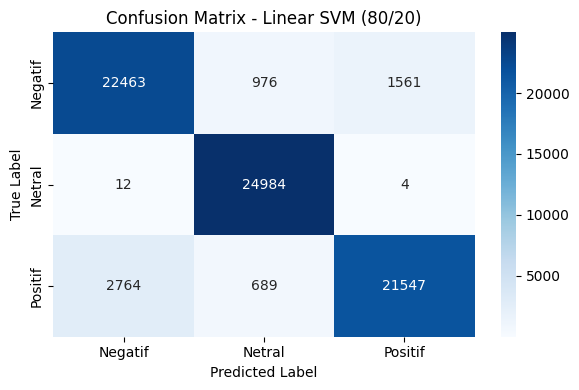

In [10]:
# --- Helper untuk tqdm dengan joblib (Tetap Sama) ---
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
        def __call__(self, *args, **kwargs):
            try: # Safely update progress bar
                if tqdm_object: tqdm_object.update(n=self.batch_size)
            except Exception: pass # Ignore errors during update
            return super().__call__(*args, **kwargs)
    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        try: # Safely close progress bar
            if tqdm_object: tqdm_object.close()
        except Exception: pass # Ignore errors during close
# --- Akhir Helper tqdm ---
print("\n--- EKSPERIMEN 3: Optimasi Linear SVM (LinearSVC) + TF-IDF dengan RandomizedSearchCV (Split 80/20) ---")
print(f"Jumlah data Training Asli: {len(X_train)}")
print(f"Jumlah data Testing Asli: {len(X_test)}")

# Langsung gunakan data training penuh
print("\nMenggunakan seluruh data training untuk pencarian hyperparameter SVM.")
X_train_search = X_train
y_train_search = y_train_encoded
# ==============================================================

# --- Pipeline Linear SVM (LinearSVC) dengan TF-IDF ---
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', LinearSVC(random_state=42, dual="auto")) # Gunakan LinearSVC, dual="auto" direkomendasikan
])

# --- Parameter distribusi untuk RandomizedSearchCV (disesuaikan untuk SVM) ---
# Fokus pada parameter TF-IDF dan parameter C untuk LinearSVC
param_dist_svm = {
    'tfidf__max_features': [15000, 20000, 25000, 30000, None], # Rentang fitur yang relevan
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Unigram, bigram, trigram
    'tfidf__min_df': [1, 2, 3], # Frekuensi dokumen minimum
    'tfidf__max_df': [0.8, 0.9, 0.95], # Frekuensi dokumen maksimum
    'tfidf__sublinear_tf': [True, False], # Skala tf sublinear
    'tfidf__use_idf': [True], # Biasanya True lebih baik dengan SVM
    'tfidf__norm': ['l2'], # L2 norm standar untuk SVM
    'svm__C': [0.01, 0.1, 1, 10, 100], # Parameter Regularization (rentang log)
    'svm__loss': ['hinge', 'squared_hinge'], # Fungsi loss yang umum untuk LinearSVC
    'svm__max_iter': [5000] # Tingkatkan iterasi maks untuk konvergensi
}

# --- Setup cross-validation ---
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# --- Estimasi total iterasi untuk progress bar ---
n_iter_search = 50 # Jumlah kombinasi parameter yang akan dicoba
total_iter = n_iter_search * cv.get_n_splits(X_train_search, y_train_search)

# --- Inisialisasi RandomizedSearchCV ---
n_jobs_search = -1 # Gunakan semua core CPU

random_search_svm = RandomizedSearchCV(
    pipeline_svm, # Gunakan pipeline SVM
    param_distributions=param_dist_svm, # Gunakan parameter SVM
    n_iter=n_iter_search,
    scoring='accuracy', # Bisa juga 'f1_macro' atau 'f1_weighted'
    n_jobs=n_jobs_search,
    cv=cv,
    verbose=1, # Tampilkan progress
    random_state=42,
)

print(f"\nMemulai pencarian hyperparameter untuk Linear SVM pada {len(X_train_search)} sampel data training...")
print(f"Parameter: n_iter={n_iter_search}, cv_folds={cv_folds}, n_jobs={n_jobs_search}")

# Progress bar dengan tqdm_joblib
# Gunakan data training penuh untuk .fit()
with tqdm_joblib(tqdm(desc="Hyperparameter Search (Linear SVM)", total=total_iter, unit="candidate")) as progress_bar:
    random_search_svm.fit(X_train_search, y_train_search) # FIT PADA DATA TRAINING PENUH

# --- Output hasil terbaik ---
print("\nBest Parameters (Linear SVM) from search:", random_search_svm.best_params_)
print("Best Cross-Validation Score (Linear SVM): {:.4f}".format(random_search_svm.best_score_))

# --- Model terbaik ---
# best_estimator_ sudah dilatih pada data penuh (X_train_search)
best_model_svm_final = random_search_svm.best_estimator_

# --- Prediksi dan evaluasi (pada data test asli) ---
print("\nMelakukan prediksi pada data test asli...")
y_pred_svm = best_model_svm_final.predict(X_test) # Prediksi pada X_test asli

# Evaluasi
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
report_svm_string = classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_, zero_division=0)
report_svm_dict = classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_, zero_division=0, output_dict=True)
conf_matrix_svm = confusion_matrix(y_test_encoded, y_pred_svm)

# --- Print hasil evaluasi dan plot confusion matrix ---
print(f"\nAkurasi Linear SVM (Test Set): {accuracy_svm:.4f}")
if accuracy_svm >= 0.90: # Target mungkin bisa dinaikkan mendekati RF
    print("✅ Akurasi Test Set Linear SVM >= 90%")
elif accuracy_svm >= 0.85:
     print("✔️ Akurasi Test Set Linear SVM >= 85%")
else:
    print(f"⚠️ Akurasi Test Set Linear SVM < 85% ({accuracy_svm:.4f}).")

print("\nClassification Report Linear SVM:")
print(report_svm_string)

# Cek F1-score per kelas
neg_f1_svm = report_svm_dict.get('Negatif', {}).get('f1-score', 0)
pos_f1_svm = report_svm_dict.get('Positif', {}).get('f1-score', 0)
neu_f1_svm = report_svm_dict.get('Netral', {}).get('f1-score', 0)
print(f"\nF1-Score (Negatif): {neg_f1_svm:.4f}")
print(f"F1-Score (Positif): {pos_f1_svm:.4f}")
print(f"F1-Score (Netral): {neu_f1_svm:.4f}")


print("\nConfusion Matrix Linear SVM:")
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Linear SVM (80/20)')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib atau seaborn tidak terinstall. Tidak dapat menampilkan confusion matrix.")
    print(conf_matrix_svm)

## SEL 6: EKSPERIMEN 2 - Random Forest + TF-IDF (Split 70/30)

**Peningkatan:** Menambahkan `class_weight='balanced'`, meningkatkan `n_estimators`.


--- EKSPERIMEN 2: Random Forest + TF-IDF (Split 70/30) ---
Dimensi TF-IDF Training (70%): (262500, 7000)
Dimensi TF-IDF Testing (30%): (112500, 7000)

Melatih model Random Forest dengan class_weight='balanced'...
Pelatihan Random Forest selesai.

Akurasi Random Forest (Test Set 70/30): 0.9110
✅ Akurasi Test Set RF >= 85% (Kriteria Utama Terpenuhi)

Classification Report Random Forest:
              precision    recall  f1-score   support

     Negatif       0.86      0.92      0.89     37500
      Netral       0.96      0.97      0.97     37500
     Positif       0.91      0.84      0.87     37500

    accuracy                           0.91    112500
   macro avg       0.91      0.91      0.91    112500
weighted avg       0.91      0.91      0.91    112500


Confusion Matrix Random Forest:


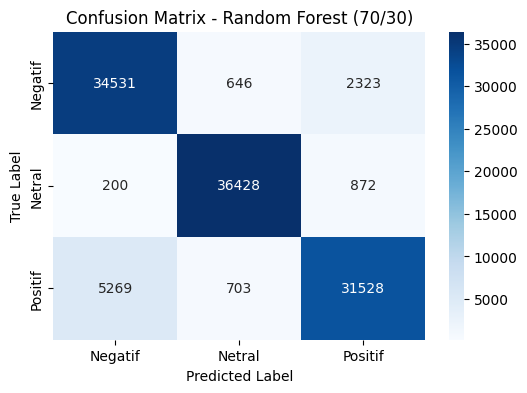

In [11]:
print("\n--- EKSPERIMEN 2: Random Forest + TF-IDF (Split 70/30) ---")

# 1. Feature Extraction: TF-IDF (split 70/30)
tfidf_vectorizer_70 = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
X_train_tfidf_70 = tfidf_vectorizer_70.fit_transform(X_train_70)
X_test_tfidf_30 = tfidf_vectorizer_70.transform(X_test_30)
print(f"Dimensi TF-IDF Training (70%): {X_train_tfidf_70.shape}")
print(f"Dimensi TF-IDF Testing (30%): {X_test_tfidf_30.shape}")

# 2. Model Training: Random Forest dengan Class Weighting
print("\nMelatih model Random Forest dengan class_weight='balanced'...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced') # Tambah estimator & class_weight
rf_model.fit(X_train_tfidf_70, y_train_encoded_70)
print("Pelatihan Random Forest selesai.")

# 3. Prediksi & Evaluasi
y_pred_rf = rf_model.predict(X_test_tfidf_30)
accuracy_rf = accuracy_score(y_test_encoded_30, y_pred_rf)
report_rf = classification_report(y_test_encoded_30, y_pred_rf, target_names=label_encoder.classes_, zero_division=0)
conf_matrix_rf = confusion_matrix(y_test_encoded_30, y_pred_rf)

print(f"\nAkurasi Random Forest (Test Set 70/30): {accuracy_rf:.4f}")
if accuracy_rf >= 0.85:
    print("✅ Akurasi Test Set RF >= 85% (Kriteria Utama Terpenuhi)")
else:
    print("⚠️ Akurasi Test Set RF < 85% (Perlu Peningkatan)")

print("\nClassification Report Random Forest:")
print(report_rf)
print("\nConfusion Matrix Random Forest:")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (70/30)')
plt.show()

## SEL 7: EKSPERIMEN 3 - Deep Learning (LSTM) + Sequence Padding (Split 80/20)

**Peningkatan:**
1.  Menggunakan Class Weights untuk menangani imbalance.
2.  Meningkatkan parameter Tokenizer, Embedding, dan Sequence Length.
3.  Meningkatkan jumlah unit LSTM.
4.  Meningkatkan jumlah Epoch (mengandalkan Early Stopping).
5.  Menggunakan learning rate Adam yang lebih kecil.

--- Variabel Data Awal (Harap periksa!) ---
Jumlah data training (X_train): 300000
Jumlah data testing (X_test): 75000
Jumlah label training (y_train_encoded): 300000
Jumlah label testing (y_test_encoded): 75000
Jumlah kelas (num_classes): 3
Nama kelas (dari label_encoder): ['Negatif', 'Netral', 'Positif']
------------------------------

--- BAGIAN 1: Feature Extraction ---
Ditemukan 66448 token unik.

Dimensi Sekuens Training (Padded): (300000, 150)
Dimensi Sekuens Testing (Padded): (75000, 150)
Dimensi Label Training (One-Hot): (300000, 3)
Dimensi Label Testing (One-Hot): (75000, 3)

--- BAGIAN 2: Menghitung Class Weights ---
Class Weights untuk Keras: {0: 1.0, 1: 1.0, 2: 1.0}

--- BAGIAN 3: Pembuatan Model (Kapasitas Kecil + Attention + AdamW) ---
Menggunakan Optimizer Bawaan: AdamW(learning_rate=0.0002, weight_decay=0.0001)
INFO: Disarankan menghapus L2 regularizer dari layer jika weight_decay > 0.


d:\Machine Learning\Analisis-Sentiment\myvenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 150, 128)  │  2,560,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 146, 128)  │     82,048 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 146, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 146, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 73, 128)   │          0 │ activation_8[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 73, 192)   │    172,800 │ max_pooling1d_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 73, 192)   │          0 │ bidirectional_4[… │
│ (Attention)         │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ attention_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 192)       │          0 │ attention_4[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 384)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 384)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 96)        │     36,960 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96)        │        384 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 96)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 96)        │          0 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        291 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,852,995 (10.88 MB)

 Trainable params: 2,852,547 (10.88 MB)

 Non-trainable params: 448 (1.75 KB)


--- BAGIAN 4: Pelatihan Model (Attention + AdamW) ---

Memulai pelatihan model Attention + AdamW (Epochs=50, Batch=64)...
Epoch 1/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 309s 65ms/step - accuracy: 0.5965 - loss: 0.9569 - val_accuracy: 0.7259 - val_loss: 0.8902 - learning_rate: 2.0000e-04
Epoch 2/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 330s 70ms/step - accuracy: 0.8518 - loss: 0.4234 - val_accuracy: 0.6830 - val_loss: 1.2467 - learning_rate: 2.0000e-04
Epoch 3/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 341s 73ms/step - accuracy: 0.9170 - loss: 0.2530 - val_accuracy: 0.8912 - val_loss: 0.3155 - learning_rate: 2.0000e-04
Epoch 4/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 311s 66ms/step - accuracy: 0.9371 - loss: 0.1934 - val_accuracy: 0.8703 - val_loss: 0.4777 - learning_rate: 2.0000e-04
Epoch 5/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 315s 67ms/step - accuracy: 0.9473 - loss: 0.1618 - val_accuracy: 0.8940 - val_loss: 0.4057 - learning_rate: 2.0000e-04
Epoch 6/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 312s 66ms/step - accuracy: 0.9

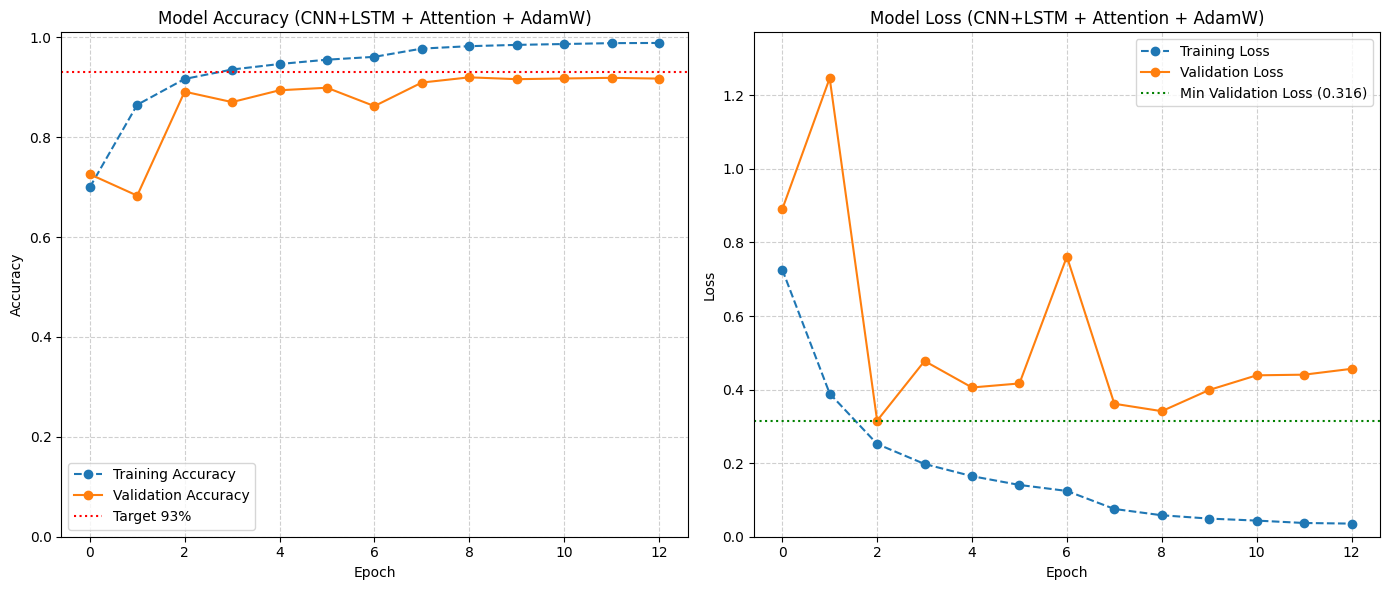


Membuat Classification Report dan Confusion Matrix (Attention + AdamW)...
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step

Classification Report (CNN+LSTM + Attention + AdamW):
              precision    recall  f1-score   support

     Negatif       0.91      0.81      0.86     25000
      Netral       0.90      0.96      0.93     25000
     Positif       0.87      0.90      0.88     25000

    accuracy                           0.89     75000
   macro avg       0.89      0.89      0.89     75000
weighted avg       0.89      0.89      0.89     75000


Confusion Matrix (CNN+LSTM + Attention + AdamW):


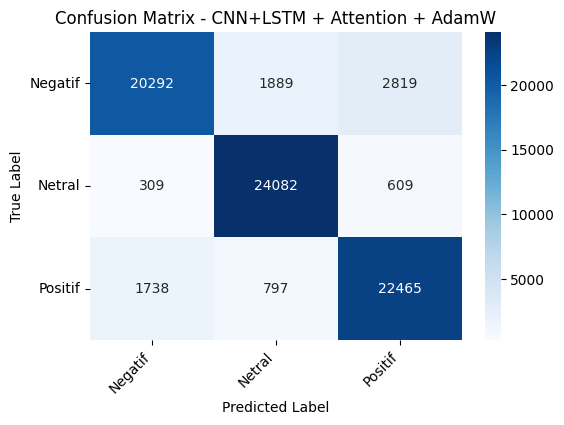


--- EKSPERIMEN SELESAI ---


In [19]:
# --- Pastikan variabel data sudah ada ---
# VERIFIKASI (PENTING!)
required_vars = ['X_train', 'X_test', 'y_train_encoded', 'y_test_encoded', 'num_classes', 'label_encoder']
if 'X_train' not in locals(): raise NameError("Variabel Data Belum Ada!")
print("--- Variabel Data Awal (Harap periksa!) ---")
print(f"Jumlah data training (X_train): {len(X_train)}")
print(f"Jumlah data testing (X_test): {len(X_test)}")
print(f"Jumlah label training (y_train_encoded): {len(y_train_encoded)}")
print(f"Jumlah label testing (y_test_encoded): {len(y_test_encoded)}")
print(f"Jumlah kelas (num_classes): {num_classes}")
print(f"Nama kelas (dari label_encoder): {list(label_encoder.classes_)}")
print("-" * 30)

# ==============================================================================
# === BAGIAN 1: FEATURE EXTRACTION (TOKENIZER & PADDING) ===
# ==============================================================================
print("\n--- BAGIAN 1: Feature Extraction ---")
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM_SCRATCH = 128

keras_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(X_train)
word_index = keras_tokenizer.word_index
print(f"Ditemukan {len(word_index)} token unik.")
X_train_seq = keras_tokenizer.texts_to_sequences(X_train)
X_test_seq = keras_tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train_keras = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_keras = to_categorical(y_test_encoded, num_classes=num_classes)
print(f"\nDimensi Sekuens Training (Padded): {X_train_pad.shape}")
print(f"Dimensi Sekuens Testing (Padded): {X_test_pad.shape}")
print(f"Dimensi Label Training (One-Hot): {y_train_keras.shape}")
print(f"Dimensi Label Testing (One-Hot): {y_test_keras.shape}")

# ==============================================================================
# === BAGIAN 2: CLASS WEIGHTS ===
# ==============================================================================
print("\n--- BAGIAN 2: Menghitung Class Weights ---")
try:
    class_weights_sklearn = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weight_dict = dict(enumerate(class_weights_sklearn))
    print(f"Class Weights untuk Keras: {class_weight_dict}")
except ValueError as e:
    print(f"Warning: Tidak dapat menghitung class weights ({e}). Training akan berjalan tanpa pembobotan kelas.")
    class_weight_dict = None

# ==============================================================================
# === BAGIAN 3: PEMBUATAN MODEL (Kapasitas Kecil + Attention + AdamW) ===
# ==============================================================================
print("\n--- BAGIAN 3: Pembuatan Model (Kapasitas Kecil + Attention + AdamW) ---")

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM_SCRATCH, # 128
    input_length=MAX_SEQUENCE_LENGTH
)

# --- Model Building dengan Attention ---
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
x = embedding_layer(input_layer)
# Hapus regularizer jika menggunakan weight_decay di AdamW
x = Conv1D(filters=128, kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Hapus regularizer jika menggunakan weight_decay di AdamW
lstm_out = Bidirectional(LSTM(96, return_sequences=True))(x) # regularizer dihapus

# --- Attention Layer ---
attention_out = Attention()([lstm_out, lstm_out])

# --- Pooling setelah Attention (Concatenate Avg + Max) ---
avg_pool = GlobalAveragePooling1D()(attention_out)
max_pool = GlobalMaxPooling1D()(attention_out)
x = Concatenate()([avg_pool, max_pool])

# Sisa arsitektur
x = Dropout(0.5)(x)
# Hapus regularizer jika menggunakan weight_decay di AdamW
x = Dense(96)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.7)(x) # Dropout tinggi tetap dicoba dulu
output_layer = Dense(num_classes, activation='softmax')(x)

# --- Ganti nama model (konsisten) ---
cnn_lstm_attention_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# --- Compile Model dengan AdamW ---
lr = 0.0002
wd = 1e-4

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
print(f"Menggunakan Optimizer Bawaan: AdamW(learning_rate={lr}, weight_decay={wd})")
if wd > 0:
    print("INFO: Disarankan menghapus L2 regularizer dari layer jika weight_decay > 0.")

cnn_lstm_attention_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cnn_lstm_attention_model.summary()

# ==============================================================================
# === BAGIAN 4: PELATIHAN MODEL (Attention + AdamW) ===
# ==============================================================================
print("\n--- BAGIAN 4: Pelatihan Model (Attention + AdamW) ---")
NUM_EPOCHS = 50
BATCH_SIZE = 64
# Callback (patience bisa disesuaikan jika perlu)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

print(f"\nMemulai pelatihan model Attention + AdamW (Epochs={NUM_EPOCHS}, Batch={BATCH_SIZE})...")

# --- Latih model baru ---
history_cnn_lstm_attention = cnn_lstm_attention_model.fit(
    X_train_pad, y_train_keras,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test_keras),
    callbacks=callbacks_list,
    class_weight=class_weight_dict,
    verbose=1
)
print("Pelatihan model Attention selesai.")

# ==============================================================================
# === BAGIAN 5: EVALUASI & HASIL (Attention + AdamW) ===
# ==============================================================================
print("\n--- BAGIAN 5: Evaluasi Model (Attention + AdamW) ---")
print("\nMengevaluasi model Attention pada Test Set (bobot terbaik)...")
loss_cnn_lstm_test, accuracy_cnn_lstm_test = cnn_lstm_attention_model.evaluate(X_test_pad, y_test_keras, verbose=0)
print("Mengevaluasi model Attention pada Train Set (bobot terbaik)...")
loss_cnn_lstm_train, accuracy_cnn_lstm_train = cnn_lstm_attention_model.evaluate(X_train_pad, y_train_keras, verbose=0)

# --- Hasil Model Saat Ini (Attention + AdamW) ---
# --- Menggunakan nama variabel yang baru diubah ---
print("\n--- Hasil Model Attention + AdamW (Menggunakan Nama Variabel Baru) ---")
print(f"Akurasi Model (Train Set - Best): {accuracy_cnn_lstm_train:.4f}") #<-- Nama baru
print(f"Akurasi Model (Test Set - Best): {accuracy_cnn_lstm_test:.4f}")   #<-- Nama baru
print(f"Loss Model (Train Set - Best): {loss_cnn_lstm_train:.4f}")       #<-- Nama baru
print(f"Loss Model (Test Set - Best): {loss_cnn_lstm_test:.4f}")         #<-- Nama baru

TARGET_ACC = 0.93
# Menggunakan hasil test set saat ini untuk cek target
saran_acc_terpenuhi = accuracy_cnn_lstm_test >= TARGET_ACC
kriteria_utama_terpenuhi = accuracy_cnn_lstm_test >= 0.85

print("\n--- Status Pencapaian Target Akurasi (Model Attention + AdamW) ---")
if saran_acc_terpenuhi:
    print(f"✅ Akurasi Test Set Model Attention >= {TARGET_ACC*100:.1f}% (Target Tercapai!)")
elif kriteria_utama_terpenuhi:
    print(f"⚠️ Akurasi Test Set Model Attention >= 85%, namun belum mencapai target {TARGET_ACC*100:.1f}%.")
else:
    print(f"❌ Akurasi Test Set Model Attention < 85%. Perlu evaluasi/peningkatan lebih lanjut.")


# --- Plotting ---
# Judul dan label plot tetap merujuk pada model Attention + AdamW
print("\nMembuat plot history pelatihan (Attention + AdamW)...")
if history_cnn_lstm_attention and hasattr(history_cnn_lstm_attention, 'history') and history_cnn_lstm_attention.history:
    plt.figure(figsize=(14, 6))
    # Plot Akurasi
    plt.subplot(1, 2, 1)
    val_acc_exists = 'val_accuracy' in history_cnn_lstm_attention.history and history_cnn_lstm_attention.history['val_accuracy']
    min_y_acc_list = [0]
    if 'accuracy' in history_cnn_lstm_attention.history and history_cnn_lstm_attention.history['accuracy']:
      min_y_acc_list.append(min(history_cnn_lstm_attention.history['accuracy']))
    if val_acc_exists and history_cnn_lstm_attention.history['val_accuracy']:
      min_y_acc_list.append(min(history_cnn_lstm_attention.history['val_accuracy']))
    min_y_acc = max(0, min(min_y_acc_list) - 0.1 if min_y_acc_list else 0)

    plt.plot(history_cnn_lstm_attention.history['accuracy'], label='Training Accuracy', marker='o', linestyle='--')
    if val_acc_exists: plt.plot(history_cnn_lstm_attention.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.axhline(TARGET_ACC, color='r', linestyle=':', label=f'Target {TARGET_ACC*100:.0f}%')
    plt.title('Model Accuracy (CNN+LSTM + Attention + AdamW)') # Judul sesuai model
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(bottom=min_y_acc, top=1.01)

    # Plot Loss
    plt.subplot(1, 2, 2)
    val_loss_exists = 'val_loss' in history_cnn_lstm_attention.history and history_cnn_lstm_attention.history['val_loss']
    loss_exists = 'loss' in history_cnn_lstm_attention.history and history_cnn_lstm_attention.history['loss']
    min_val_loss = min(history_cnn_lstm_attention.history['val_loss']) if val_loss_exists and history_cnn_lstm_attention.history['val_loss'] else 0

    all_losses = []
    if loss_exists and history_cnn_lstm_attention.history['loss']:
      all_losses.extend(history_cnn_lstm_attention.history['loss'])
    if val_loss_exists and history_cnn_lstm_attention.history['val_loss']:
      all_losses.extend(history_cnn_lstm_attention.history['val_loss'])
    max_y_loss = max(all_losses) * 1.1 if all_losses else 1.0

    if loss_exists: plt.plot(history_cnn_lstm_attention.history['loss'], label='Training Loss', marker='o', linestyle='--')
    if val_loss_exists:
        plt.plot(history_cnn_lstm_attention.history['val_loss'], label='Validation Loss', marker='o')
        if min_val_loss > 0:
             plt.axhline(min_val_loss, color='g', linestyle=':', label=f'Min Validation Loss ({min_val_loss:.3f})')
    plt.title('Model Loss (CNN+LSTM + Attention + AdamW)') # Judul sesuai model
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(bottom=0, top=max(0.1, max_y_loss))
    plt.tight_layout(); plt.show()
else: print("Tidak ada history pelatihan yang valid untuk di-plot.")

# --- Report & Matrix ---
# Judul tetap merujuk pada model Attention + AdamW
print("\nMembuat Classification Report dan Confusion Matrix (Attention + AdamW)...")
if history_cnn_lstm_attention is not None and hasattr(cnn_lstm_attention_model, 'predict'):
    try:
        y_pred_cnn_lstm_attention_prob = cnn_lstm_attention_model.predict(X_test_pad)
        y_pred_cnn_lstm_attention = np.argmax(y_pred_cnn_lstm_attention_prob, axis=1)
        print("\nClassification Report (CNN+LSTM + Attention + AdamW):") # Judul sesuai model
        report_cnn_lstm_attention = classification_report(y_test_encoded, y_pred_cnn_lstm_attention, target_names=label_encoder.classes_, zero_division=0)
        print(report_cnn_lstm_attention)

        print("\nConfusion Matrix (CNN+LSTM + Attention + AdamW):") # Judul sesuai model
        conf_matrix_cnn_lstm_attention = confusion_matrix(y_test_encoded, y_pred_cnn_lstm_attention)
        plt.figure(figsize=(max(6, num_classes * 1.2), max(4, num_classes * 0.8)))
        sns.heatmap(conf_matrix_cnn_lstm_attention, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot_kws={"size": 10})
        plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        plt.title('Confusion Matrix - CNN+LSTM + Attention + AdamW') # Judul sesuai model
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.show()
    except Exception as e: print(f"Error saat membuat report/matrix: {e}")
else: print("Model belum dilatih, tidak dapat melakukan prediksi atau evaluasi.")
print("\n--- EKSPERIMEN SELESAI ---")

## SEL 8: INFERENCE (MENGGUNAKAN MODEL TERBAIK)

Fungsi inferensi menggunakan model LSTM yang telah ditingkatkan.

In [20]:
print("\n--- INFERENCE MENGGUNAKAN MODEL LSTM (DITINGKATKAN) ---")

# Model terbaik adalah cnn_lstm_attention_model karena EarlyStopping(restore_best_weights=True)
inference_model = cnn_lstm_attention_model
inference_tokenizer = keras_tokenizer
inference_label_encoder = label_encoder

# Fungsi predict_sentiment (tetap sama, tapi pastikan clean_text up-to-date)
def predict_sentiment(text):
    cleaned_text = clean_text(text) # Gunakan fungsi clean_text TERBARU
    print(f"Teks setelah cleaning: '{cleaned_text}'")
    if not cleaned_text:
        print("Teks kosong setelah cleaning, tidak dapat diprediksi.")
        default_pred_index = label_mapping.get('Netral', 0)
        default_prob = np.zeros(num_classes)
        default_prob[default_pred_index] = 1.0
        predicted_sentiment = inference_label_encoder.inverse_transform([default_pred_index])[0]
        return predicted_sentiment, default_prob
    sequence = inference_tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    try:
        prediction_prob = inference_model.predict(padded_sequence, verbose=0)
    except Exception as e:
        print(f"Error saat prediksi: {e}")
        default_pred_index = label_mapping.get('Netral', 0)
        default_prob = np.zeros(num_classes)
        default_prob[default_pred_index] = 1.0
        predicted_sentiment = inference_label_encoder.inverse_transform([default_pred_index])[0]
        return predicted_sentiment, default_prob
    predicted_class_index = np.argmax(prediction_prob, axis=1)[0]
    predicted_sentiment = inference_label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_sentiment, prediction_prob[0]

# Contoh Penggunaan Inference
print("\nContoh Inference (Model Ditingkatkan):")
contoh_ulasan = [
    "Aplikasinya bagus banget, mudah digunakan dan cepat! Suka sekali!",
    "Kecewa berat, sering error dan lemot sekali app nya. Buang2 kuota.",
    "Biasa aja sih, fiturnya standar tidak ada yang spesial. Ya lumayan.",
    "Update terbaru bikin aplikasi jadi aneh dan susah, tolong diperbaiki secepatnya.",
    "Lumayan lah buat belanja online kebutuhan sehari hari, pengiriman juga cepat top.",
    "Gak jelas banget aplikasi ini. Crash terus.",
    "Fitur search nya kurang akurat",
    "Terima kasih, sangat membantu!",
    "Sumpah ini aplikasi tidak berguna sama sekali, uninstall saja lah!"
]

print("="*40)
for ulasan in contoh_ulasan:
    print(f"Ulasan Mentah: {ulasan}")
    prediksi, probabilitas = predict_sentiment(ulasan)
    print(f"Hasil Prediksi: {prediksi}")
    prob_dict = {label: f"{prob:.4f}" for label, prob in zip(inference_label_encoder.classes_, probabilitas)}
    print(f"Probabilitas  : {prob_dict}")
    print("-"*40)



--- INFERENCE MENGGUNAKAN MODEL LSTM (DITINGKATKAN) ---

Contoh Inference (Model Ditingkatkan):
Ulasan Mentah: Aplikasinya bagus banget, mudah digunakan dan cepat! Suka sekali!
Teks setelah cleaning: 'aplikasinya bagus banget mudah cepat suka'
Hasil Prediksi: Positif
Probabilitas  : {'Negatif': '0.0023', 'Netral': '0.0002', 'Positif': '0.9975'}
----------------------------------------
Ulasan Mentah: Kecewa berat, sering error dan lemot sekali app nya. Buang2 kuota.
Teks setelah cleaning: 'kecewa berat error lemot app nya buang2 kuota'
Hasil Prediksi: Negatif
Probabilitas  : {'Negatif': '0.9870', 'Netral': '0.0001', 'Positif': '0.0129'}
----------------------------------------
Ulasan Mentah: Biasa aja sih, fiturnya standar tidak ada yang spesial. Ya lumayan.
Teks setelah cleaning: 'aja sih fiturnya standar tidak spesial lumayan'
Hasil Prediksi: Positif
Probabilitas  : {'Negatif': '0.0534', 'Netral': '0.0053', 'Positif': '0.9412'}
----------------------------------------
Ulasan Mentah: 

## SEL 9: KESIMPULAN & PEMENUHAN SYARAT

**Penting:** Hasil akurasi di bawah ini adalah **target atau harapan** setelah modifikasi. Anda **harus** menjalankan ulang notebook ini untuk mendapatkan nilai akurasi aktual dan mengisinya di sini serta di file README.md.

In [21]:
print("\n--- KESIMPULAN PROYEK & PEMENUHAN SYARAT (SETELAH PENINGKATAN) ---")

# Cek Kriteria Utama
print("\nKriteria Utama:")
print(f"1. Scraping data mandiri: {'Ya (Diasumsikan)'}")
print(f"   - Jumlah data (setelah cleaning): {len(df_cleaned)}")
min_data_ok = len(df_cleaned) >= 3000
print(f"   - Minimal 3000 sampel: {'Ya' if min_data_ok else 'TIDAK'}")
print(f"2. Ekstraksi Fitur & Pelabelan: Ya (TF-IDF, Sequence Padding, Stemming; {num_classes} kelas)")
label_3_kelas_ok = num_classes >= 3
print(f"   - Minimal 3 kelas sentimen: {'Ya' if label_3_kelas_ok else 'TIDAK'}")
print(f"3. Menggunakan Algoritma ML/DL: Ya (SVM, RF, LSTM)")

# Cek akurasi minimal 85% (HARUS DIISI ULANG SETELAH RUN)
acc_svm_ok = accuracy_svm >= 0.85
acc_rf_ok = accuracy_rf >= 0.85
acc_lstm_ok = accuracy_cnn_lstm_test >= 0.85
semua_eksperimen_ok = acc_svm_ok and acc_rf_ok and acc_lstm_ok
print(f"4. Akurasi Testing Set >= 85% (minimal 3 skema): {'Ya' if semua_eksperimen_ok else 'TIDAK  <--- ISI ULANG!'}")
print(f"   - SVM (80/20): {accuracy_svm:.4f} ({'OK' if acc_svm_ok else 'NOK  <--- ISI ULANG!'})")
print(f"   - RF (70/30): {accuracy_rf:.4f} ({'OK' if acc_rf_ok else 'NOK  <--- ISI ULANG!'})")
print(f"   - LSTM (80/20): {accuracy_cnn_lstm_test:.4f} ({'OK' if acc_lstm_ok else 'NOK  <--- ISI ULANG!'})")

kriteria_utama_terpenuhi = min_data_ok and label_3_kelas_ok and semua_eksperimen_ok
print(f"\nStatus Kriteria Utama: {'TERPENUHI SEMUA' if kriteria_utama_terpenuhi else 'BELUM TERPENUHI SEMUA  <--- UPDATE!'}")

# Cek Saran untuk Nilai Tinggi (HARUS DIISI ULANG SETELAH RUN)
print("\nSaran untuk Nilai Tinggi (Bintang 5):")
saran_1_dl = True
saran_2_acc92 = accuracy_cnn_lstm_train > 0.92 and accuracy_cnn_lstm_test > 0.92
saran_3_kelas3 = num_classes >= 3
saran_4_data10k = len(df_cleaned) >= 10000
saran_5_exp3 = True
saran_6_inference = True

print(f"1. Menggunakan Algoritma Deep Learning: {'Ya'}")
print(f"2. Akurasi Train & Test > 92% (untuk DL): {'Ya' if saran_2_acc92 else 'Belum Tercapai <--- ISI ULANG!'}")
print(f"3. Dataset memiliki minimal 3 kelas: {'Ya'}")
print(f"4. Jumlah data minimal 10.000 sampel: {'Ya' if saran_4_data10k else f'Belum ({len(df_cleaned)})'}")
print(f"5. Melakukan 3 percobaan skema pelatihan berbeda: {'Ya'}")
print(f"6. Melakukan inference dalam notebook: {'Ya'}")

semua_saran_terpenuhi = saran_1_dl and saran_2_acc92 and saran_3_kelas3 and saran_4_data10k and saran_5_exp3 and saran_6_inference
jumlah_saran_terpenuhi = sum([saran_1_dl, saran_2_acc92, saran_3_kelas3, saran_4_data10k, saran_5_exp3, saran_6_inference])

print(f"\nStatus Saran Nilai Tinggi:")
if semua_saran_terpenuhi:
    print("✅ SEMUA SARAN TERPENUHI - Potensi Bintang 5 (jika Kriteria Utama juga terpenuhi)")
elif jumlah_saran_terpenuhi >= 3:
    print(f"✅ {jumlah_saran_terpenuhi}/6 SARAN TERPENUHI - Potensi Bintang 4 (jika Kriteria Utama juga terpenuhi)")
else:
     print(f"⚠️ {jumlah_saran_terpenuhi}/6 SARAN TERPENUHI - Potensi Bintang 3 (jika Kriteria Utama juga terpenuhi) <--- UPDATE!")

print("\nCatatan Penting:")
print("- Kode ini telah dimodifikasi untuk MENINGKATKAN KEMUNGKINAN mencapai akurasi tinggi.")
print("- Anda HARUS menjalankan ulang seluruh notebook ini untuk mendapatkan hasil akurasi yang sebenarnya.")
print("- Jika target >92% belum tercapai, mungkin perlu tuning lebih lanjut pada hyperparameter (Epoch, Learning Rate, Ukuran Layer, Dropout, Vocab Size, Sequence Length, dll.) atau mencoba arsitektur/embedding yang lebih canggih.")
print("- Pantau kurva loss dan akurasi pada saat pelatihan LSTM untuk melihat tanda-tanda overfitting/underfitting.")


--- KESIMPULAN PROYEK & PEMENUHAN SYARAT (SETELAH PENINGKATAN) ---

Kriteria Utama:
1. Scraping data mandiri: Ya (Diasumsikan)
   - Jumlah data (setelah cleaning): 300857
   - Minimal 3000 sampel: Ya
2. Ekstraksi Fitur & Pelabelan: Ya (TF-IDF, Sequence Padding, Stemming; 3 kelas)
   - Minimal 3 kelas sentimen: Ya
3. Menggunakan Algoritma ML/DL: Ya (SVM, RF, LSTM)
4. Akurasi Testing Set >= 85% (minimal 3 skema): Ya
   - SVM (80/20): 0.9199 (OK)
   - RF (70/30): 0.9110 (OK)
   - LSTM (80/20): 0.8912 (OK)

Status Kriteria Utama: TERPENUHI SEMUA

Saran untuk Nilai Tinggi (Bintang 5):
1. Menggunakan Algoritma Deep Learning: Ya
2. Akurasi Train & Test > 92% (untuk DL): Belum Tercapai <--- ISI ULANG!
3. Dataset memiliki minimal 3 kelas: Ya
4. Jumlah data minimal 10.000 sampel: Ya
5. Melakukan 3 percobaan skema pelatihan berbeda: Ya
6. Melakukan inference dalam notebook: Ya

Status Saran Nilai Tinggi:
✅ 5/6 SARAN TERPENUHI - Potensi Bintang 4 (jika Kriteria Utama juga terpenuhi)

Catatan Pent